# Time Series Forecast - VNINDEX

In [ ]:
#import necessary libraries
import statsmodels.api as sm
import matplotlib.pyplot as plt
from vnstock import Quote
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

## 1.Import Data

In [17]:
end_date = '2025-10-25'

start_date_object = pd.to_datetime(end_date) - pd.DateOffset(years=15)
start_date_string = start_date_object.strftime('%Y-%m-%d')

quote = Quote(symbol='VNINDEX', source='VCI')
df = quote.history(start=start_date_string, end=end_date,index=True)

df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)

df



,open,high,low,close,volume
time,,,,,
2010-10-25,444.70,448.60,443.10,448.60,23427100
2010-10-26,450.20,458.20,450.20,455.10,30139330
2010-10-27,455.20,455.90,448.90,450.00,23349570
2010-10-28,448.60,451.50,448.30,450.10,20155160
2010-10-29,450.50,452.80,450.30,452.60,22494310
...,...,...,...,...,...
2025-10-06,1673.16,1695.50,1664.17,1695.50,1087044888
2025-10-07,1703.90,1703.90,1678.66,1685.30,879953011
2025-10-08,1701.06,1704.42,1680.87,1697.83,1067425184


## 2.Exploratory Data Analysis (EDA)

In [3]:
print(df.describe())

print(df.info())

              open         high          low        close        volume
count  3735.000000  3735.000000  3735.000000  3735.000000  3.735000e+03
mean    859.858137   865.259162   853.695106   859.747660  3.085798e+08
std     336.908505   338.819831   334.046796   336.744681  3.235361e+08
min     334.930000   339.320000   332.280000   336.730000  0.000000e+00
25%     560.625000   564.715000   557.415000   560.985000  8.878622e+07
50%     872.690000   876.970000   868.210000   873.470000  1.536348e+08
75%    1148.925000  1156.715000  1138.090000  1149.315000  5.121481e+08
max    1725.270000  1747.570000  1721.760000  1747.550000  2.698902e+09
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3735 entries, 2010-10-25 to 2025-10-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3735 non-null   float64
 1   high    3735 non-null   float64
 2   low     3735 non-null   float64
 3   close   3735 non-null   float64
 4   v

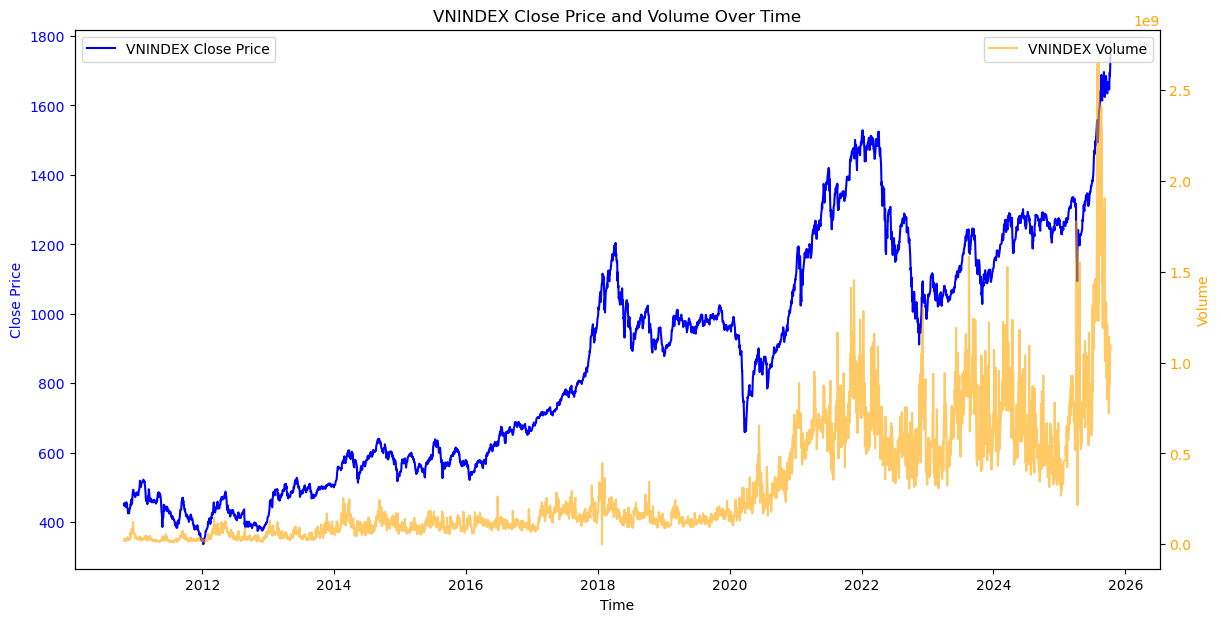

In [4]:
fig1, ax1 = plt.subplots(figsize=(14,7))
# Plot close price
ax1.plot(df.index, df['close'], label='VNINDEX Close Price', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
# plot volume on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(df.index, df['volume'], label='VNINDEX Volume', color='orange', alpha=0.6)
ax2.set_ylabel('Volume', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

plt.title('VNINDEX Close Price and Volume Over Time')
plt.show()

In [26]:
# Decompose with annual-like period (252 trading days per year)
decomposition = sm.tsa.seasonal_decompose(df['close'], model='additive', period=252)

trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

# “Shock” = close price - trend - seasonality (optional metric)
shock = df['close'] - trend - seasonality

# Combine to visualize as full time series
time_series = df['close']

# --------------------------------------------------------------
# 3️⃣ Create interactive subplots
# --------------------------------------------------------------
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=('Complete Time Series', 'Trend Component', 'Seasonal Component', 'Residual (Shock)'),
    vertical_spacing=0.08,
    row_heights=[0.4, 0.2, 0.2, 0.2]
)

# 1. Complete Time Series
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=time_series,
        mode='lines',
        line=dict(color='rgba(255, 0, 255, 1)'),
        name='Time Series'
    ),
    row=1, col=1
)

# 2. Trend
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=trend,
        mode='lines',
        line=dict(color='rgba(0, 255, 0, 1)'),
        name='Trend'
    ),
    row=2, col=1
)

# 3. Seasonality
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=seasonality,
        mode='lines',
        line=dict(color='rgba(0, 255, 255, 1)'),
        name='Seasonality'
    ),
    row=3, col=1
)

# 4. Residual / Shock
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=residual,
        mode='lines',
        line=dict(color='rgba(255, 20, 147, 1)'),
        name='Residual'
    ),
    row=4, col=1
)

# --------------------------------------------------------------
# 4️⃣ Update layout & aesthetics
# --------------------------------------------------------------
fig.update_layout(
    height=1000,
    width=1200,
    showlegend=False,
    title_text=f"VNINDEX Time Series Decomposition ({start_date_string} → {end_date})",
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(color='white')
)

fig.update_xaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor='rgba(128,128,128,0.2)',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='rgba(128,128,128,0.5)'
)
fig.update_yaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor='rgba(128,128,128,0.2)',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='rgba(128,128,128,0.5)'
)

fig.show()

In [ ]:
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=('Filtering', 'Smoothing', 'Forecasting'),
    vertical_spacing=0.08,
    row_heights=[0.33, 0.33, 0.33]
)

# ==============================================================
# 🌀 FILTERING: Moving Average
# ==============================================================
window = 20
filtered = np.convolve(df['close'], np.ones(window)/window, mode='valid')
filtered_df = pd.DataFrame(filtered, index=df.index[window-1:])
filtered_dates = filtered_df.index

filtered_std = np.std(filtered)
filtered_upper = filtered + 2*filtered_std
filtered_lower = filtered - 2*filtered_std

# Original Data
fig.add_trace(
    go.Scatter(x=df.index, y=df['close'], mode='lines', line=dict(color='rgba(0,255,255,1)'), name='Original'),
    row=1, col=1
)

# Filtered Line
fig.add_trace(
    go.Scatter(x=filtered_dates, y=filtered, mode='lines', line=dict(color='rgba(255,20,147,1)'), name='Filtered'),
    row=1, col=1
)

# Confidence Band
fig.add_trace(
    go.Scatter(x=filtered_dates, y=filtered_upper, mode='lines', line=dict(color='rgba(255,20,147,0.2)'), showlegend=False),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=filtered_dates, y=filtered_lower, mode='lines', line=dict(color='rgba(255,20,147,0.2)'), fill='tonexty', showlegend=False),
    row=1, col=1
)

# 🌊 SMOOTHING: Exponential Smoothing
# ==============================================================
alpha = 0.1
smoothed = [df['close'][0]]
for i in range(1, len(df['close'])):
    smoothed.append(alpha * df['close'][i] + (1 - alpha) * smoothed[i-1])

smoothed_std = np.std(smoothed)
smoothed_std = np.std(smoothed)
smoothed_upper = np.array(smoothed) + 2*smoothed_std
smoothed_lower = np.array(smoothed) - 2*smoothed_std

fig.add_trace(
    go.Scatter(x=df.index, y=df['close'], mode='lines', line=dict(color='rgba(0,255,255,1)'), showlegend=False),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.index, y=smoothed, mode='lines', line=dict(color='rgba(147,0,255,1)'), name='Smoothed'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.index, y=smoothed_upper, mode='lines', line=dict(color='rgba(147,0,255,0.2)'), showlegend=False),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.index, y=smoothed_lower, mode='lines', line=dict(color='rgba(147,0,255,0.2)'), fill='tonexty', showlegend=False),
    row=2, col=1
)



# 🔮 FORECASTING: Simple Random Walk Projection
# ==============================================================
forecast_days = 360
last_price = df['close'].iloc[-1]
forecast = [last_price]
forecast_std_list = []
current_std = np.std(df['close'].iloc[-window:])

for _ in range(forecast_days-1):
    forecast.append(forecast[-1] * (1 + np.random.normal(0.0003, 0.01)))
    current_std *= 1.1
    forecast_std_list.append(current_std)

forecast_dates = [df.index[-1] + timedelta(days=i) for i in range(forecast_days)]

forecast_std = np.std(df['close'].iloc[-window:])
forecast_upper = np.array(forecast) + 2 * forecast_std
forecast_lower = np.array(forecast) - 2 * forecast_std

fig.add_trace(
    go.Scatter(x=df.index, y=df['close'], mode='lines', line=dict(color='rgba(0,255,255,1)'), showlegend=False),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=forecast_dates, y=forecast, mode='lines', line=dict(color='rgba(57,255,20,1)'), name='Forecast'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=forecast_dates, y=forecast_upper, mode='lines', line=dict(color='rgba(57,255,20,0.2)'), showlegend=False),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=forecast_dates, y=forecast_lower, mode='lines', line=dict(color='rgba(57,255,20,0.2)'), fill='tonexty', showlegend=False),
    row=3, col=1
)

# --------------------------------------------------------------
# 4️⃣ Layout settings
# --------------------------------------------------------------
fig.update_layout(
    width=1200,
    height=1200,
    title='Time Series Analysis on VNINDEX: Filtering, Smoothing, and Forecasting',
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(color='white')
)

fig.update_xaxes(
    showgrid=True,
    gridcolor='rgba(128,128,128,0.2)',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='rgba(128,128,128,0.5)'
)
fig.update_yaxes(
    showgrid=True,
    gridcolor='rgba(128,128,128,0.2)',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='rgba(128,128,128,0.5)'
)

fig.show()